<a href="https://colab.research.google.com/github/husam1986/RAN_Chest_x_ray/blob/main/2class-c-p_my_alterd_RAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Husam Imad**
2 classes _ classify coveid & Pneumonia 
new code for RAN 


ref:
https://github.com/Jay4869/Deep-Learning

https://github.com/husam1986/RAN_Chest_x_ray

https://www.kaggle.com/code/ankan1998/covid19-detection-using-tensorflow-from-chest-xray


intialize

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply

from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import time, os, datetime
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

import os
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,TensorBoard, LearningRateScheduler
from tensorflow.keras.models import load_model


1- Residual_Unit

In [ ]:

"""
Residual Unit is implemented above proposed Residual Block
input >> BN >> ReLU >> Conv2DLayer(1,1)
      >> BN >> ReLU >> Conv2DLayer(3,3)
      >> BN >> ReLU >> Conv2DLayer(1,1) + identify
      >> output
"""

def Residual_Unit(input, in_channel, out_channel, stride=1):

    """
    :param input: The input of the Residual_Unit. Should be a 4D array like (batch_num, img_len, img_len, channel_num)
    :param in_channel: The 4-th dimension (channel number) of input matrix. For example, in_channel=3 means the input contains 3 channels.
    :param out_channel: The 4-th dimension (channel number) of output matrix. For example, out_channel=5 means the output contains 5 channels (feature maps).
    :param stride: Integer. The number of pixels to move between 2 neighboring receptive fields.
    """

    # initialize as the input (identity) data
    shortcut = input
    shortcut = Conv2D(out_channel, (1, 1), padding='same', strides=stride)(shortcut)

    # RestNet module
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv2D(in_channel, (1, 1))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(in_channel, (3, 3), padding='same', strides=stride)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(out_channel, (1, 1), padding='same')(x)

    # identity
    x = Add()([x, shortcut])

    return x

2- Attention_Block

In [ ]:

"""from .Residual_Unit import Residual_Unit"""

"""
Attention_Block
input >> Max Pooling >> Residual Block (p)
      >> (1 + Soft Mask Branch) * Trunk Branch
      >> Residual Block (p)
      >> output
      
Soft Mask Branch
input >> down sampling >> skip connections >> down sampling
      >> up sampling >> skip connections >> up sampling
      >> add skip connections
      >> conv(1,1) >> conv(1,1) >> sigmoid
"""

def Attention_Block(input, skip):

    """
    :param input: The input of the Residual_Unit. Should be a 4D array like (batch_num, img_len, img_len, channel_num)
    :param in_channel: The 4-th dimension (channel number) of input matrix. For example, in_channel=3 means the input contains 3 channels.
    """

    # initial Attention Module parameters
    p = 1
    t = 2
    r = 1
    skip_connections = []
    # calculate input and output channel based on previous layers
    in_channel = input.shape[-1]
    out_channel = in_channel

    # pre-activation Residual Unit
    for _ in range(p):
        x = Residual_Unit(input, in_channel, out_channel)

    # Trunk Branch
    for _ in range(t):
        Trunck_output = Residual_Unit(x, in_channel, out_channel)

    # Soft Mask Branch
    ## 1st down sampling
    x = MaxPooling2D(padding='same')(x)
    for _ in range(r):
        x = Residual_Unit(x, in_channel, out_channel)

    if x.shape[1] % 4 == 0:
        for i in range(skip-1):
            ## skip connections
            skip_connections.append(Residual_Unit(x, in_channel, out_channel))

            ## 2rd down sampling
            x = MaxPooling2D(padding='same')(x)
            for _ in range(r):
                x = Residual_Unit(x, in_channel, out_channel)

        skip_connections = list(reversed(skip_connections))

        for i in range(skip-1):
            ## 1st up sampling
            for _ in range(r):
                x = Residual_Unit(x, in_channel, out_channel)
            x = UpSampling2D()(x)

            # skip connections
            x = Add()([x, skip_connections[i]])

    ## 2rd up samplping
    for i in range(r):
        x = Residual_Unit(x, in_channel, out_channel)
    x = UpSampling2D()(x)

    ## output
    x = Conv2D(out_channel, (1, 1))(x)
    x = Conv2D(out_channel, (1, 1))(x)
    soft_mask_output = Activation('sigmoid')(x)

    # Attention: (1 + soft_mask_output) * Trunck_output
    soft_mask_output = Lambda(lambda x: x + 1)(soft_mask_output)
    output = Multiply()([soft_mask_output, Trunck_output])

    # Last Residual Block
    for i in range(p):
        output = Residual_Unit(output, in_channel, out_channel)

    return output


*3*- AttentionResNet56

In [ ]:
def AttentionResNet56(shape, in_channel, kernel_size, n_classes, dropout=None, regularization=0.01):

    """
    :param shape: The tuple of input data.
    :param in_channel: The 4-th dimension (channel number) of input weight matrix. For example, in_channel=3 means the input contains 3 channels.
    :param kernel_size: Integer. the shape of the kernel. For example, default kernel_size = 3 means you have a 3*3 kernel.
    :param n_classes: Integer. The number of target classes. For example, n_classes = 10 means you have 10 class labels.
    :param dropout: Float between 0 and 1. Fraction of the input units to drop.
    :param regularization: Float. Fraction of the input units to drop.
    """
    print("1- input +++++++++++")
    input_data = Input(shape=shape)  # 512x512x2    
    x = Conv2D(in_channel, kernel_size=kernel_size, padding='same')(input_data)  # 256x256x32 
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 256x256x32

    print("2- Attention 1 +++++++++++")
    x = Attention_Block(x, skip=1)
    print("3- Residual_Unit 1 +++++++++++")
    out_channel = in_channel * 2  # 64
    x = Residual_Unit(x, in_channel, out_channel)  # 256x256x64
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 128x128x64 
    
    """in_channel=out_channel
    out_channel = in_channel * 2 # 128
    x = Residual_Unit(x, in_channel, out_channel)  # 64x64x128
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 32x32x128
"""
    print("4- Attention 2 +++++++++++")
    x = Attention_Block(x, skip=1)

    print("5- Residual_Unit 2 +++++++++++")
    in_channel=out_channel
    out_channel = in_channel * 2 # 128
    x = Residual_Unit(x, in_channel, out_channel)  # 128x128x128
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 64x64x128
    print("6- Attention 3 +++++++++++")
    x = Attention_Block(x, skip=1)
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 32x32x128
    print("7- Residual_Unit 3 +++++++++++")
    in_channel=out_channel
    out_channel = in_channel * 2  # 256
    x = Residual_Unit(x, in_channel, out_channel)  # 32x32x256
    x =  MaxPooling2D(pool_size=2, padding='same')(x)  # 16x16x256
    print("8- Residual_Unit 4 +++++++++++")
    in_channel=out_channel
    out_channel = in_channel * 2
    x = Residual_Unit(x, in_channel, out_channel)  # 16x16x512
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 8x8x512
    print("9- Residual_Unit 5 +++++++++++")
    in_channel=out_channel
    """out_channel = in_channel * 2"""
    x = Residual_Unit(x, in_channel, out_channel)  # 8x8x512
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 4x4x512
    print("10- Residual_Unit 6 +++++++++++")
    x = Residual_Unit(x, in_channel, out_channel)  # 4x4x512
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 2x2x512
    x = Flatten()(x) # 

    output = Dense(n_classes, kernel_regularizer=l2(regularization), activation='softmax')(x)
    model = Model(input_data, output)

    return model

My_AttentionResNet56

In [ ]:
"""
def My_AttentionResNet56(shape, in_channel, kernel_size, n_classes, dropout=None, regularization=0.01):

    input_data = Input(shape=shape)  # 64x64x3    
    x = Conv2D(in_channel, kernel_size=kernel_size, padding='same')(input_data)  # 64x64x32 

    x = Attention_Block(x, skip=2)
    out_channel = in_channel * 2  # 64
    x = Residual_Unit(x, in_channel, out_channel)  # 64x64x64
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 32x32x64

    x = Attention_Block(x, skip=1)
    in_channel=out_channel
    out_channel = in_channel * 2 # 128
    x = Residual_Unit(x, in_channel, out_channel)  # 32x32x128
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 16x16x128

    x = Attention_Block(x, skip=1)
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 8x8x128
    in_channel=out_channel
    out_channel = in_channel * 2  # 256
    x = Residual_Unit(x, in_channel, out_channel)  # 8x8x256
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 4x4x256
    x = Residual_Unit(x, in_channel, out_channel)  # 4x4x256
    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 2x2x256

    x = Flatten()(x) # 1024

    output = Dense(n_classes, kernel_regularizer=l2(regularization), activation='softmax')(x)
    model = Model(input_data, output)

    return model"""

"\ndef My_AttentionResNet56(shape, in_channel, kernel_size, n_classes, dropout=None, regularization=0.01):\n\n    input_data = Input(shape=shape)  # 64x64x3    \n    x = Conv2D(in_channel, kernel_size=kernel_size, padding='same')(input_data)  # 64x64x32 \n\n    x = Attention_Block(x, skip=2)\n    out_channel = in_channel * 2  # 64\n    x = Residual_Unit(x, in_channel, out_channel)  # 64x64x64\n    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 32x32x64\n\n    x = Attention_Block(x, skip=1)\n    in_channel=out_channel\n    out_channel = in_channel * 2 # 128\n    x = Residual_Unit(x, in_channel, out_channel)  # 32x32x128\n    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 16x16x128\n\n    x = Attention_Block(x, skip=1)\n    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 8x8x128\n    in_channel=out_channel\n    out_channel = in_channel * 2  # 256\n    x = Residual_Unit(x, in_channel, out_channel)  # 8x8x256\n    x = MaxPooling2D(pool_size=2, padding='same')(x)  # 4x4x256\n 

4-1 hardwer info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

  from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


  
print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

/bin/bash: nvidia-smi: command not found
Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!
TF version:  2.12.0
Keras version: 2.12.0


Extracting Files

In [ ]:
c = '/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images'
n = '/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/images'
p = '/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [ ]:
random.seed(42)
"""filenames = os.listdir(c)[1:1200] + os.listdir(n) + os.listdir(p)[1:1200]"""
filenames = os.listdir(c)[1:1300] + os.listdir(p)[1:1300]


In [ ]:
categories = []
for filename in filenames:
    """fileLastname = filename.split('/')[-1:][0]"""
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(1))
    elif category == 'Viral Pneumonia':
        categories.append(str(0))
    
    else: print(filename)

Converting to Dataframe

In [ ]:
from posix import remove

for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    
    else: print(filenames[i])

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
"""df = df_t.sample(frac=1)"""

df.head()

,filename,category
0,/content/drive/Othercomputers/Hp8570/GoogleDri...,1
1,/content/drive/Othercomputers/Hp8570/GoogleDri...,1
2,/content/drive/Othercomputers/Hp8570/GoogleDri...,1
3,/content/drive/Othercomputers/Hp8570/GoogleDri...,1
4,/content/drive/Othercomputers/Hp8570/GoogleDri...,1


Exploratory Data Analysis

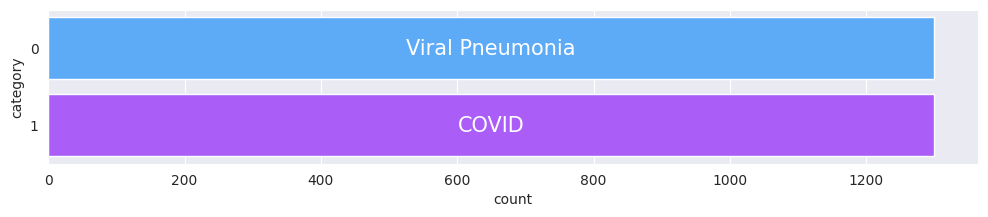

In [ ]:
plt.figure(figsize=(12,2))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Viral Pneumonia', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

Data Visualization

/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images/COVID-748.png


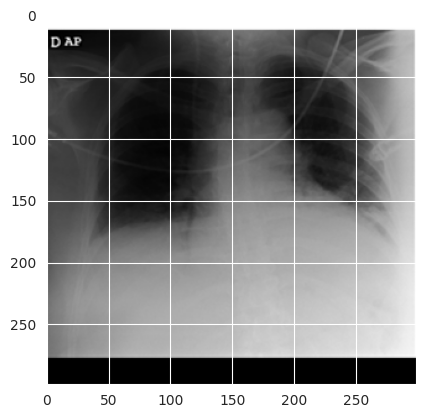

/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images/COVID-2339.png


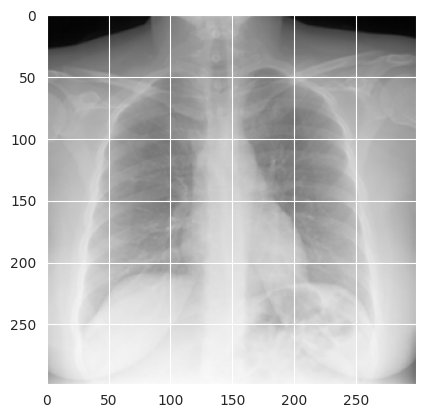

/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images/COVID-1646.png


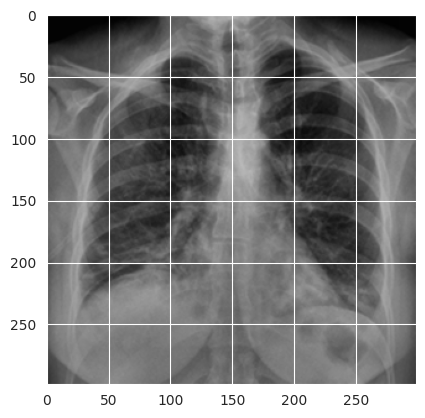

/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images/COVID-1167.png
/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images/COVID-716.png
/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/AI Work/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images/COVID-809.png


In [ ]:
sample = random.choice(df['filename'])
image = load_img(sample)
print(sample)
plt.imshow(image)
plt.show()
sample = random.choice(df['filename'])
image = load_img(sample)
print(sample)
plt.imshow(image)
plt.show()
sample = random.choice(df['filename'])
image = load_img(sample)
print(sample)
plt.imshow(image)
plt.show()

sample = random.choice(df['filename'])
print(sample)
sample = random.choice(df['filename'])
print(sample)
sample = random.choice(df['filename'])
print(sample)


Splitting Train, Validation & Test Data

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

no Data Augmentation

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(512,512),
    class_mode='categorical',
    batch_size=32
)

Found 2078 validated image filenames belonging to 2 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(512,512),
    class_mode='categorical',
    batch_size=32
)

Found 260 validated image filenames belonging to 2 classes.


7- Set Learning Rate and Optimizer


In [ ]:
# define learning rate scheduler
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 120:
        lr *= 1e-3
    elif epoch > 50:
        lr *= 1e-2
    elif epoch > 5:
        lr *= 1e-1
    print('Learning rate:', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

# define model
model = AttentionResNet56(shape=(512,512,3), in_channel=32, kernel_size=3, n_classes=2, dropout=0.4, regularization=0.01)

# define loss, metrics, optimizer
# optimizer = SGD(lr = lr_schedule(0), momentum=0.9, nesterov=True)
optimizer = Adam( lr_schedule(0) )
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

1- input +++++++++++
2- Attention 1 +++++++++++
3- Residual_Unit 1 +++++++++++
4- Attention 2 +++++++++++
5- Residual_Unit 2 +++++++++++
6- Attention 3 +++++++++++
7- Residual_Unit 3 +++++++++++
8- Residual_Unit 4 +++++++++++
9- Residual_Unit 5 +++++++++++
10- Residual_Unit 6 +++++++++++
Learning rate: 0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                

8-Training and Evaluation


In [ ]:
# training
batch_size = 128
epc = 40

start = time.time()
"""
# training
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
step_size_train = train_generator.n // train_generator.batch_size

# validation
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)
step_size_val = val_generator.n // val_generator.batch_size

# test
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)
step_size_test = test_generator.n // test_generator.batch_size
"""
# usefull callbacks
log_dir='Logs/' + '56full'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
"""lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)
early_stopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)"""
"""
model.fit_generator(train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = epc,
                    validation_data = val_generator,
                    validation_steps = step_size_val,
                    callbacks=[tensorboard_callback, lr_reducer, lr_scheduler, early_stopper])
"""
history = model.fit(train_generator,validation_data=valid_generator,epochs = epc,
          callbacks=[tensorboard_callback, lr_scheduler])

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

# evaluation
val_scores = model.evaluate_generator(valid_generator, verbose=0)
"""test_scores = model.evaluate_generator(test_generator, verbose=1)"""
print('validation loss:', val_scores[0])
print('validation accuracy:', val_scores[1])


Learning rate: 0.001
Epoch 1/40
65/65 [==============================] - 1345s 20s/step - loss: 2.2643 - accuracy: 0.8653 - val_loss: 1.7736 - val_accuracy: 0.5000 - lr: 0.0010
Learning rate: 0.001
Epoch 2/40
65/65 [==============================] - 1308s 20s/step - loss: 0.3283 - accuracy: 0.9379 - val_loss: 2.1889 - val_accuracy: 0.5038 - lr: 0.0010
Learning rate: 0.001
Epoch 3/40
65/65 [==============================] - 1310s 20s/step - loss: 0.2400 - accuracy: 0.9490 - val_loss: 0.8513 - val_accuracy: 0.6885 - lr: 0.0010
Learning rate: 0.001
Epoch 4/40
65/65 [==============================] - 1308s 20s/step - loss: 0.3020 - accuracy: 0.9350 - val_loss: 0.4917 - val_accuracy: 0.8038 - lr: 0.0010
Learning rate: 0.001
Epoch 5/40
65/65 [==============================] - 1316s 20s/step - loss: 0.2251 - accuracy: 0.9548 - val_loss: 0.4467 - val_accuracy: 0.8423 - lr: 0.0010
Learning rate: 0.001
Epoch 6/40
65/65 [==============================] - 1316s 20s/step - loss: 0.1995 - accuracy: 

Saving Model

In [2]:
model.save('/content/drive/Othercomputers/Hp8570/GoogleDrive_Hp8570/Covid-c-p-5-6.h5')

NameError: ignored

Plotting

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epc, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epc, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


9-Performance Analysis


In [ ]:
%load_ext tensorboard
%tensorboard --logdir Logs/


Model Testing

In [ ]:
sample = random.choice(test_data['filename'])

fileLastname = sample.split('/')[-1:][0]
category = fileLastname.split('-')[0]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
elif category == 'Normal':
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(512, 512))
img = img_to_array(image)
img = img.reshape((1, 512, 512, 3))
img=img.astype('float32')/ 255.0

result = model.predict(img)
print(result)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
elif result == 2:
    print("COVID +", result)
else:
  print("none")
plt.imshow(image)
